# Assignment 1

In [1]:
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

## 原始数据

In [ ]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './dataset' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)


In [ ]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

In [7]:
train_root = '../datasets/notMNIST_large/'
train_folders = [os.path.join(train_root, d) for d in sorted(os.listdir(train_root)) if os.path.isdir(os.path.join(train_root, d))]
test_root = '../datasets/notMNIST_small/'
test_folders = [os.path.join(test_root, d) for d in sorted(os.listdir(test_root)) if os.path.isdir(os.path.join(test_root, d))]

In [8]:
train_folders,test_folders

(['../datasets/notMNIST_large/A',
  '../datasets/notMNIST_large/B',
  '../datasets/notMNIST_large/C',
  '../datasets/notMNIST_large/D',
  '../datasets/notMNIST_large/E',
  '../datasets/notMNIST_large/F',
  '../datasets/notMNIST_large/G',
  '../datasets/notMNIST_large/H',
  '../datasets/notMNIST_large/I',
  '../datasets/notMNIST_large/J'],
 ['../datasets/notMNIST_small/A',
  '../datasets/notMNIST_small/B',
  '../datasets/notMNIST_small/C',
  '../datasets/notMNIST_small/D',
  '../datasets/notMNIST_small/E',
  '../datasets/notMNIST_small/F',
  '../datasets/notMNIST_small/G',
  '../datasets/notMNIST_small/H',
  '../datasets/notMNIST_small/I',
  '../datasets/notMNIST_small/J'])

In [31]:
for folder in train_folders:
    label = folder[-1]
    num = len(os.listdir(folder))
    print('{}:{}'.format(label, num))

A:52912
B:52912
C:52912
D:52912
E:52912
F:52912
G:52912
H:52912
I:52912
J:52911


In [32]:
for folder in test_folders:
    label = folder[-1]
    num = len(os.listdir(folder))
    print('{}:{}'.format(label, num))

A:1873
B:1873
C:1873
D:1873
E:1873
F:1873
G:1872
H:1872
I:1872
J:1872


## Problem 1
### 展示训练图片

In [23]:
from IPython.display import Image, HTML, display
import random

In [68]:
for folder in train_folders:
    images = os.listdir(folder)
    samples = random.sample(images,20)
    samples_path = [os.path.join(folder, name) for name in samples]
    imagesList=''.join( ["<img style='width: 32px; margin: 5px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
                         for s in samples_path])
    display(HTML(imagesList))

## 数据处理
- 将图片分批
- 将图片集转化为 3D 数组，并正则化，并按图片类别保存

In [28]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ../datasets/notMNIST_large/A.pickle.
../datasets/notMNIST_large/A
Could not read: ../datasets/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ../datasets/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ../datasets/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825027
Standard deviation: 0.4431208
Pickling ../datasets/notMNIST_large/B.pickle.
../datasets/notMNIST_large/B
Could not read: ../datasets/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.0075630466
Standard deviation: 0.4544913
Pickli

## Problem 2
### 将得到的数据显示为图片

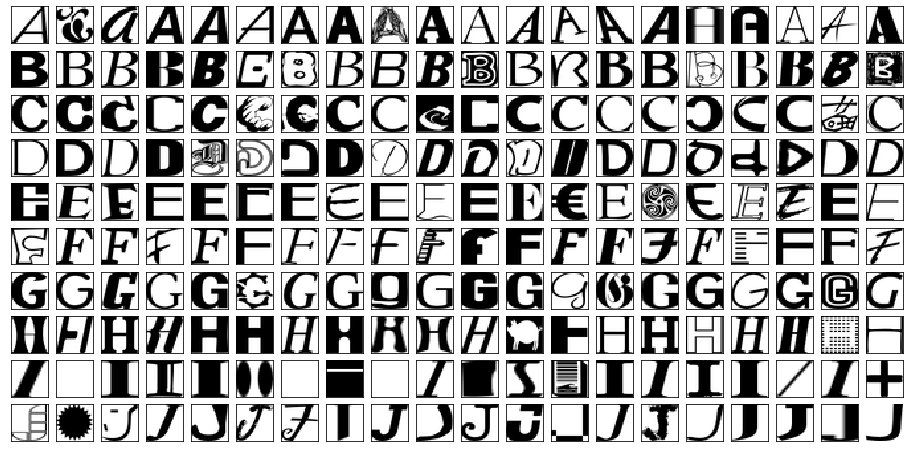

In [63]:
Nr = len(train_folders)
Nc = 20
cmap = "binary"

fig, axs = plt.subplots(Nr, Nc, figsize=(16,8))
# fig.suptitle('Multiple images')
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.axis('off')

# images = []
for i in range(Nr):
    folder = train_folders[i]
    label = folder[-1]
    with open(folder+'.pickle','rb') as f:
        dataset = pickle.load(f)
        np.random.shuffle(dataset)
        samples = dataset[:Nc]
    for j in range(Nc):
        data = samples[j]
        axs[i, j].imshow(data, cmap=cmap)
        axs[i, j].set_axis_off
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()


## 训练集、验证集、测试集

In [69]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


## Problem 3
### 判断不同数据集中样本数量按类别是否平衡

In [18]:
def data_distribution(dataset, num2letter=num2letter):
    for i in range(10):
        num = len(dataset[dataset==i])
        label = num2letter[i]
        print("{}:{}".format(label,num),end=';')


In [19]:
for cat,dataset in zip(['train','valid','test'],[train_labels,valid_labels,test_labels]):
    print(cat,end=': ')
    data_distribution(dataset)
    print()

train: A:20000;B:20000;C:20000;D:20000;E:20000;F:20000;G:20000;H:20000;I:20000;J:20000;
valid: A:1000;B:1000;C:1000;D:1000;E:1000;F:1000;G:1000;H:1000;I:1000;J:1000;
test: A:1000;B:1000;C:1000;D:1000;E:1000;F:1000;G:1000;H:1000;I:1000;J:1000;


In [76]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4
### 数据与标签是否同步重排序

In [17]:
num2letter = {}
for i,letter in enumerate('ABCDEFGHIJ'):
    num2letter[i] = letter
    
num2letter

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J'}

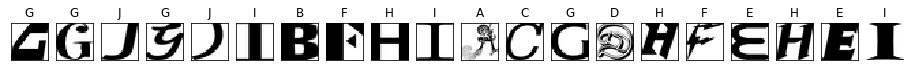

In [89]:
cmap = "binary"

fig, axs = plt.subplots(1, 20, figsize=(16,4))
plt.subplots_adjust(wspace=0.2)
plt.axis('off')

for i in range(20):
    data = train_dataset[i]
    label = train_labels[i]
    label = num2letter[label]
    axs[i].imshow(data, cmap=cmap)
    axs[i].set_axis_off
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].label_outer()
    axs[i].set_title(label)


保存处理后的数据

In [91]:
data_root = '../datasets/'
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [92]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


## Problem 5
### 找出重叠的图片
    
    - 将图片数组大于0的数值变为1，小于0的数值变为0
    - 比较两张图片，计算相同位置处数值不相同的数量，小于某一阈值，即判定为相同的照片
    
- ***todo：太耗时，待优化***

In [2]:
data_root = '../datasets/'
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
with open(pickle_file,'rb') as f:
    data = pickle.load(f)
    train_dataset = data['train_dataset']
    train_labels = data['train_labels']
    test_dataset= data['test_dataset']
    test_labels= data['test_labels']
    valid_dataset= data['valid_dataset']
    valid_labels = data[ 'valid_labels']

In [4]:
def aHash(img_array):
    mask = (img_array>0).astype(int)
    return mask.flatten()

In [5]:
def diff(img1,img2):
    hash1 = aHash(img1)
    hash2 = aHash(img2)
    diff = np.count_nonzero(hash1 != hash2)
    return diff

In [6]:
diff(train_dataset[0],train_dataset[0]),diff(train_dataset[0],train_dataset[1]),diff(train_dataset[0],train_dataset[2])

(0, 323, 304)

In [7]:
test_labels

array([9, 5, 8, ..., 5, 9, 3], dtype=int32)

In [8]:
def overlapping(img, dataset, mask):
    for i in mask:
        if diff(img, dataset[i])<5:
            return i

In [9]:
def find_overlappings(valid_dataset,valid_labels,train_dataset,train_labels):
    overlapping_index=[]
    
    for i,img in enumerate(valid_dataset):
        label = valid_labels[i]
        mask = np.where(train_labels==label)[0]
        
        j = overlapping(img, train_dataset, mask)
        if j is not None:
            overlapping_index.append((i,j))
    return overlapping_index      

#### 验证集去重

In [10]:
%%time
overlapping_index = find_overlappings(valid_dataset,valid_labels,train_dataset,train_labels)

CPU times: user 32min 21s, sys: 300 ms, total: 32min 21s
Wall time: 32min 21s


In [11]:
overlapping_index

[(1, 183513),
 (2, 50023),
 (3, 85595),
 (8, 7778),
 (18, 115172),
 (23, 93739),
 (27, 184312),
 (32, 119397),
 (37, 17642),
 (39, 27),
 (65, 93350),
 (77, 62297),
 (81, 6216),
 (82, 41547),
 (93, 32350),
 (101, 4628),
 (105, 145752),
 (113, 15312),
 (114, 77430),
 (117, 181640),
 (123, 18427),
 (124, 134197),
 (137, 3442),
 (146, 131311),
 (158, 27),
 (159, 125142),
 (163, 27),
 (169, 166088),
 (170, 13263),
 (176, 58397),
 (179, 27),
 (189, 197128),
 (192, 254),
 (212, 13145),
 (216, 30811),
 (223, 86647),
 (225, 169198),
 (227, 16658),
 (228, 6520),
 (230, 35258),
 (235, 1759),
 (243, 132131),
 (254, 188492),
 (257, 97740),
 (259, 27),
 (263, 28637),
 (274, 115884),
 (278, 106254),
 (281, 119474),
 (285, 26782),
 (293, 5024),
 (295, 6018),
 (297, 20445),
 (301, 27),
 (309, 159528),
 (320, 62363),
 (324, 22953),
 (331, 89432),
 (334, 27),
 (335, 21068),
 (343, 54603),
 (348, 7596),
 (352, 1310),
 (361, 55901),
 (365, 2916),
 (369, 27),
 (373, 71143),
 (376, 27),
 (377, 143839),
 (378

In [14]:
def img_comparision(dataset1,name1,dataset2,name2,overlappings,num=20):
    cmap = "binary"
    fig, axs = plt.subplots(2, num, figsize=(16,2))
    plt.subplots_adjust(wspace=0.2)
    plt.axis('off')
    
    for k in range(20):
        i,j = overlappings[k]
        train = train_dataset[j]
        valid = valid_dataset[i]

        axs[0,k].imshow(train, cmap=cmap)
        axs[0,k].set_axis_off
        axs[0,k].set_title(name1)
        axs[0,k].set_xticks([])
        axs[0,k].set_yticks([])

        axs[1,k].imshow(valid, cmap=cmap)
        axs[1,k].set_axis_off
        axs[1,k].set_title(name2)
        axs[1,k].set_xticks([])
        axs[1,k].set_yticks([])
    

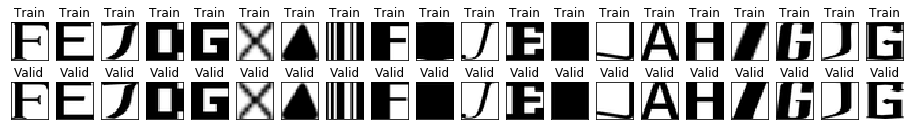

In [24]:
img_comparision(train_dataset,'Train',valid_dataset,'Valid',overlapping_index)

In [19]:
overlapping_mask = np.array(overlapping_index)[:,0]
mask = np.setdiff1d(np.arange(len(valid_dataset)),overlapping_mask)
sanitized_valid_dataset = valid_dataset[mask]
sanitized_valid_labels = valid_labels[mask]

In [20]:
len(sanitized_valid_dataset)

7924

In [12]:
data_distribution(sanitized_valid_labels)

0:848;1:879;2:850;3:815;4:811;5:779;6:873;7:711;8:559;9:799;

#### 测试集去重

- 测试集与训练集

In [26]:
overlapping_index1 = find_overlappings(test_dataset,test_labels,train_dataset,train_labels)

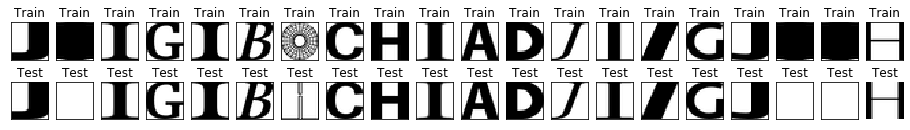

In [29]:
img_comparision(train_dataset,'Train',test_dataset,'Test',overlapping_index1)

**全黑与全空白被判定为相同的图片？？？**

In [33]:
i,j = overlapping_index1[1]
i,j

(2, 27)

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5],
       [0.

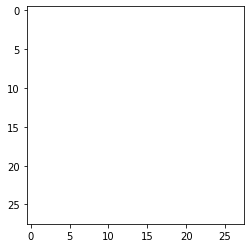

In [34]:
plt.imshow(test_dataset[i], cmap=cmap)
test_dataset[i]

array([[0.40588236, 0.40588236, 0.40588236, 0.41764706, 0.43333334,
        0.45294118, 0.46862745, 0.4882353 , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.4882353 , 0.46862745, 0.45294118, 0.43333334, 0.41764706,
        0.40588236, 0.40588236, 0.40588236],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       ],
       [0.49607843, 0.49607843, 0.49607843, 0.49607843, 0.49607843,
        0.49607843, 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5   

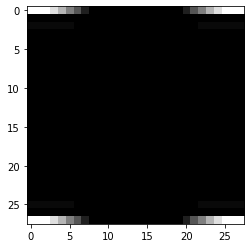

In [36]:
plt.imshow(train_dataset[j], cmap=cmap)
train_dataset[j]

- 测试集与验证集

In [37]:
%%time
overlapping_index2 = find_overlappings(test_dataset,test_labels,sanitized_valid_dataset,sanitized_valid_labels)

CPU times: user 1min 28s, sys: 2 ms, total: 1min 28s
Wall time: 1min 28s


In [38]:
overlapping_mask1 = np.array(overlapping_index1)[:,0]
overlapping_mask2 = np.array(overlapping_index2)[:,0]
mask = np.setdiff1d(np.arange(len(test_dataset)),np.union1d(overlapping_mask1, overlapping_mask2))

sanitized_test_dataset = test_dataset[mask]
sanitized_test_labels = test_labels[mask]

In [11]:
print(len(sanitized_test_labels))
data_distribution(sanitized_test_labels)

7438
0:780;1:850;2:807;3:779;4:759;5:720;6:847;7:635;8:522;9:739;

In [40]:
data_root = '../datasets/'
pickle_file = os.path.join(data_root, 'sanitized_notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'valid_train_overlapping_index':overlapping_index,
    'test_train_overlapping_index':overlapping_index1, 
    'test_sani_valid_overlapping_index':overlapping_index2, 
      
    'sanitized_test_dataset': sanitized_test_dataset,
    'sanitized_test_labels': sanitized_test_labels,
    'sanitized_valid_dataset': sanitized_valid_dataset,
    'sanitized_valid_labels': sanitized_valid_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

## Problem 6
### 创建分类模型

In [4]:
data_root = '../datasets/'
pickle_file = os.path.join(data_root,'sanitized_notMNIST.pickle')
with open(pickle_file,'rb') as f:
    data = pickle.load(f)
    sanitized_test_dataset = data['sanitized_test_dataset']
    sanitized_test_labels = data['sanitized_test_labels']
    sanitized_valid_dataset= data['sanitized_valid_dataset']
    sanitized_valid_labels = data[ 'sanitized_valid_labels']

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
train_dataset = train_dataset.reshape((-1,28*28))

In [7]:
valid_dataset = valid_dataset.reshape((-1,28*28))
test_dataset = test_dataset.reshape((-1,28*28))

In [8]:
sanitized_test_dataset = sanitized_test_dataset.reshape((-1,28*28))
sanitized_valid_dataset = sanitized_valid_dataset.reshape((-1,28*28))

In [20]:
for num in [50,100,1000,5000]:
    print('First {} samples'.format(num),end=':')
    data_distribution(train_labels[:num])
    print()

First 50 samples:A:3;B:4;C:3;D:5;E:6;F:6;G:6;H:6;I:6;J:5;
First 100 samples:A:12;B:9;C:9;D:8;E:15;F:7;G:10;H:10;I:10;J:10;
First 1000 samples:A:99;B:89;C:87;D:86;E:110;F:100;G:98;H:108;I:112;J:111;
First 5000 samples:A:476;B:494;C:524;D:471;E:512;F:519;G:483;H:524;I:501;J:496;


In [22]:
%%time 
clfs = []
accs = []
nums = [50,100,1000,5000]
for num in nums:
    clf = LogisticRegression()
    clf.fit(train_dataset[:num],train_labels[:num])
    clfs.append(clf)
    
    valid_pred = clf.predict(valid_dataset)
    acc = accuracy_score(valid_pred, valid_labels)
    accs.append(acc)

/home/student/anaconda3/envs/noam/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/student/anaconda3/envs/noam/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/student/anaconda3/envs/noam/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/student/anaconda3/envs/noam/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/student/anaconda3/envs/n

CPU times: user 40.7 s, sys: 259 ms, total: 41 s
Wall time: 39.1 s


In [32]:
accs

[0.6084, 0.6977, 0.7677, 0.7828]

Text(0, 0.5, 'accuracy')

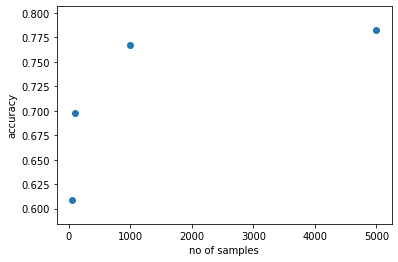

In [24]:
plt.scatter(nums,accs)
plt.xlabel('no of samples')
plt.ylabel('accuracy')

In [35]:
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

**训练样本从1000增加到5000，验证精度从 76.8% 增加到 78.3%**

In [29]:
def confusion_matrix(y_pred, y_true):
    cm = np.zeros((10,10))
    t = np.arange(len(y_true))
    for i in range(10):
        for j in range(10):
            cm[i,j]=len(t[(y_pred==i)&(y_true==j)])

- 原始的测试集及验证集

In [25]:
clf = clfs[3]
train_pred = clf.predict(train_dataset)
accuracy_score(train_pred, train_labels)

0.78337

In [26]:
valid_pred = clf.predict(valid_dataset)
accuracy_score(valid_pred, valid_labels)

0.7828

In [27]:
test_pred = clf.predict(test_dataset)
accuracy_score(test_pred, test_labels)

0.8576

- 去重的测试集及验证集

In [26]:
sanitized_valid_pred = clf.predict(sanitized_valid_dataset)
accuracy_score(sanitized_valid_pred, sanitized_valid_labels)

0.7651438667339727

In [27]:
sanitized_test_pred = clf.predict(sanitized_test_dataset)
accuracy_score(sanitized_test_pred, sanitized_test_labels)

0.8339607421349825

**去重后，验证集和测试集的预测精度分别下降 1.5% 和 2.4%**

In [34]:
from itertools import product

- C=1.0, penalty='l2'

In [56]:
classifiers = []

In [57]:
%%time
penalty = ['l1','l2']
C = [1, 10]

for p,c in product(penalty, C):
    clf = LogisticRegression(penalty=p,C=c)
    clf.fit(train_dataset[:10000],train_labels[:10000])
    classifiers.append(clf)

/home/student/anaconda3/envs/noam/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/student/anaconda3/envs/noam/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/student/anaconda3/envs/noam/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/student/anaconda3/envs/noam/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/student/anaconda3/envs/n

CPU times: user 15min 26s, sys: 1.85 s, total: 15min 28s
Wall time: 15min 28s


In [58]:
classifiers

[LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l1',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l1',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticReg

In [59]:
accs = []
for clf in classifiers:
    sanitized_valid_pred = clf.predict(sanitized_valid_dataset)
    acc = accuracy_score(sanitized_valid_pred, sanitized_valid_labels)
    accs.append(acc)

In [60]:
accs

[0.7695608278647148,
 0.7248864209994952,
 0.7651438667339727,
 0.7318273599192328]

In [61]:
best_clf = classifiers[0]
best_clf

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
sanitized_test_pred = best_clf.predict(sanitized_test_dataset)
accuracy_score(sanitized_test_pred, sanitized_test_labels)

0.8439096531325625

# Assignment 2
- Deep Learning

In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [41]:
pickle_file = '../datasets/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


去重的数据

In [42]:
pickle_file = '../datasets/sanitized_notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  sanitized_valid_dataset = save['sanitized_valid_dataset']
  sanitized_valid_labels = save['sanitized_valid_labels']
  sanitized_test_dataset = save['sanitized_test_dataset']
  sanitized_test_labels = save['sanitized_test_labels']
  del save  # hint to help gc free up memory|
  print('sanitized_Validation set', sanitized_valid_dataset.shape, sanitized_valid_labels.shape)
  print('sanitized_Test set', sanitized_test_dataset.shape, sanitized_test_labels.shape)

sanitized_Validation set (7924, 28, 28) (7924,)
sanitized_Test set (7438, 28, 28) (7438,)


## 数据处理
- 将图片的28x28数据，转化为一维向量
- 将每个标签转化为one-hoet向量

In [43]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [44]:
sanitized_valid_dataset, sanitized_valid_labels = reformat(sanitized_valid_dataset, sanitized_valid_labels)
sanitized_test_dataset, sanitized_test_labels = reformat(sanitized_test_dataset, sanitized_test_labels)
print('sanitized_Validation set', sanitized_valid_dataset.shape, sanitized_valid_labels.shape)
print('sanitized_Test set', sanitized_test_dataset.shape, sanitized_test_labels.shape)

sanitized_Validation set (7924, 784) (7924, 10)
sanitized_Test set (7438, 784) (7438, 10)


## TensorFlow，多分类逻辑回归，梯度下降

In [128]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [129]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [130]:
num_steps = 801

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 21.951445
Training accuracy: 7.6%
Validation accuracy: 12.1%
Loss at step 100: 2.229361
Training accuracy: 72.8%
Validation accuracy: 71.6%
Loss at step 200: 1.789998
Training accuracy: 75.5%
Validation accuracy: 74.1%
Loss at step 300: 1.558776
Training accuracy: 76.9%
Validation accuracy: 74.6%
Loss at step 400: 1.404579
Training accuracy: 77.8%
Validation accuracy: 74.9%
Loss at step 500: 1.290256
Training accuracy: 78.6%
Validation accuracy: 75.3%
Loss at step 600: 1.200214
Training accuracy: 79.2%
Validation accuracy: 75.6%
Loss at step 700: 1.126540
Training accuracy: 79.6%
Validation accuracy: 75.8%
Loss at step 800: 1.064710
Training accuracy: 79.9%
Validation accuracy: 76.0%
Test accuracy: 83.1%


### 随机梯度下降

In [131]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [132]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 20.930994
Minibatch accuracy: 6.2%
Validation accuracy: 8.8%
Minibatch loss at step 500: 1.645523
Minibatch accuracy: 78.1%
Validation accuracy: 76.7%
Minibatch loss at step 1000: 1.300367
Minibatch accuracy: 79.7%
Validation accuracy: 77.3%
Minibatch loss at step 1500: 1.049319
Minibatch accuracy: 80.5%
Validation accuracy: 78.0%
Minibatch loss at step 2000: 1.111283
Minibatch accuracy: 82.8%
Validation accuracy: 78.9%
Minibatch loss at step 2500: 0.775358
Minibatch accuracy: 79.7%
Validation accuracy: 79.5%
Minibatch loss at step 3000: 0.956375
Minibatch accuracy: 78.1%
Validation accuracy: 78.8%
Test accuracy: 85.4%


## Problem
### 创建2层神经网络模型，1024隐藏神经元，relu 激活函数，

In [109]:
batch_size = 128
hidden_layer_size = 1024
num_labels = 10
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32,shape=(None, image_size * image_size))
    y_ = tf.placeholder(tf.float32, shape=(None, num_labels))
    
    w1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
    b1 = tf.Variable(tf.zeros([hidden_layer_size]))
    y1 = tf.matmul(x, w1)+b1
    y1_relu = tf.nn.relu(y1)
    
    w2 = tf.Variable(tf.truncated_normal([hidden_layer_size,num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))
    y_pred = tf.matmul(y1_relu, w2)+b2
    
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_pred))
    
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    
    correct_predicetion = tf.equal(tf.argmax(y_,1), tf.argmax(y_pred, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predicetion, tf.float32))

In [110]:
num_steps = 3001

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        sess.run(train_step,feed_dict={x: batch_data, y_ :batch_labels})
        
        if (step % 500 == 0):
            loss, train_acc = sess.run([cross_entropy,accuracy],
                                       feed_dict={x: batch_data, y_ :batch_labels})
            print("step {}:".format(step))
            print("Minibatch loss: {}, accuracy: {}".format(loss,train_acc))
            val_acc = sess.run(accuracy,feed_dict={x: valid_dataset,
                                                   y_: valid_labels})
            print("Validation accuracy: {}".format(val_acc))
            print('-'*80)


    test_acc = sess.run(accuracy,feed_dict={x: test_dataset, 
                                            y_: test_labels})
    print("Test accuracy: {}".format(test_acc))
    
    sanitized_test_acc = sess.run(accuracy,feed_dict={x: sanitized_test_dataset, 
                                            y_: sanitized_test_labels})
    print("sanitized_Test accuracy: {}".format(sanitized_test_acc))

Initialized
step 0:
Minibatch loss: 960.6638793945312, accuracy: 0.5546875
Validation accuracy: 0.37630000710487366
--------------------------------------------------------------------------------
step 500:
Minibatch loss: 15.633955001831055, accuracy: 0.8984375
Validation accuracy: 0.7930999994277954
--------------------------------------------------------------------------------
step 1000:
Minibatch loss: 2.486438512802124, accuracy: 0.9140625
Validation accuracy: 0.8104000091552734
--------------------------------------------------------------------------------
step 1500:
Minibatch loss: 1.3642990589141846, accuracy: 0.9140625
Validation accuracy: 0.8201000094413757
--------------------------------------------------------------------------------
step 2000:
Minibatch loss: 1.4904862642288208, accuracy: 0.9140625
Validation accuracy: 0.8079000115394592
--------------------------------------------------------------------------------
step 2500:
Minibatch loss: 2.2373385429382324, accura

# Assignment 3
## 探索正则化技巧

## Problem 1
### l2 正则化

### 逻辑回归

In [135]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32,shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # 加入 l2 正则化
    l2_param = 0.001
    loss += l2_param * tf.nn.l2_loss(weights)

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [136]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 20.827627
Minibatch accuracy: 10.2%
Validation accuracy: 15.2%
Minibatch loss at step 500: 2.655389
Minibatch accuracy: 78.9%
Validation accuracy: 76.6%
Minibatch loss at step 1000: 1.799305
Minibatch accuracy: 82.0%
Validation accuracy: 79.2%
Minibatch loss at step 1500: 1.163723
Minibatch accuracy: 82.8%
Validation accuracy: 80.1%
Minibatch loss at step 2000: 0.965932
Minibatch accuracy: 82.8%
Validation accuracy: 81.2%
Minibatch loss at step 2500: 0.746682
Minibatch accuracy: 85.9%
Validation accuracy: 82.0%
Minibatch loss at step 3000: 0.848776
Minibatch accuracy: 78.9%
Validation accuracy: 82.0%
Test accuracy: 88.6%


**加入l2正则化，逻辑回归精度从 85.4% 提升到 88.6%**

### 神经网络

In [145]:
batch_size = 128
hidden_layer_size = 1024
num_labels = 10
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32,shape=(None, image_size * image_size))
    y_ = tf.placeholder(tf.float32, shape=(None, num_labels))
    
    w1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
    b1 = tf.Variable(tf.zeros([hidden_layer_size]))
    y1 = tf.matmul(x, w1)+b1
    y1_relu = tf.nn.relu(y1)
    
    w2 = tf.Variable(tf.truncated_normal([hidden_layer_size,num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))
    y_pred = tf.matmul(y1_relu, w2)+b2
    
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_pred))
    
    l2_param = 0.001
    cross_entropy += l2_param * (tf.nn.l2_loss(w1)+tf.nn.l2_loss(w2))
    
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    
    correct_predicetion = tf.equal(tf.argmax(y_,1), tf.argmax(y_pred, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predicetion, tf.float32))

In [146]:
num_steps = 3001

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        sess.run(train_step,feed_dict={x: batch_data, y_ :batch_labels})
        
        if (step % 500 == 0):
            loss, train_acc = sess.run([cross_entropy,accuracy],
                                       feed_dict={x: batch_data, y_ :batch_labels})
            print("step {}:".format(step))
            print("Minibatch loss: {}, accuracy: {}".format(loss,train_acc))
            val_acc = sess.run(accuracy,feed_dict={x: valid_dataset,
                                                   y_: valid_labels})
            print("Validation accuracy: {}".format(val_acc))
            print('-'*80)


    test_acc = sess.run(accuracy,feed_dict={x: test_dataset, 
                                            y_: test_labels})
    print("Test accuracy: {}".format(test_acc))
    
    sanitized_test_acc = sess.run(accuracy,feed_dict={x: sanitized_test_dataset, 
                                            y_: sanitized_test_labels})
    print("sanitized_Test accuracy: {}".format(sanitized_test_acc))

Initialized
step 0:
Minibatch loss: 1366.8778076171875, accuracy: 0.53125
Validation accuracy: 0.4366999864578247
--------------------------------------------------------------------------------
step 500:
Minibatch loss: 197.82177734375, accuracy: 0.8671875
Validation accuracy: 0.7842000126838684
--------------------------------------------------------------------------------
step 1000:
Minibatch loss: 113.80962371826172, accuracy: 0.90625
Validation accuracy: 0.8123999834060669
--------------------------------------------------------------------------------
step 1500:
Minibatch loss: 67.86046600341797, accuracy: 0.9140625
Validation accuracy: 0.8345000147819519
--------------------------------------------------------------------------------
step 2000:
Minibatch loss: 41.037872314453125, accuracy: 0.953125
Validation accuracy: 0.8529000282287598
--------------------------------------------------------------------------------
step 2500:
Minibatch loss: 25.001123428344727, accuracy: 0.91

**加入l2正则化，神经网络精度从 86.4% 提升到 91.2%**

## Problem 2
###  过拟合

In [13]:
num_steps = 3001

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print("Initialized")
    for step in range(num_steps):
        
        # 限制训练样本的数量，1000
        offset = (step * batch_size) % (200 - batch_size)
        

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        sess.run(train_step,feed_dict={x: batch_data, y_ :batch_labels})
        
        if (step % 500 == 0):
            loss, train_acc = sess.run([cross_entropy,accuracy],
                                       feed_dict={x: batch_data, y_ :batch_labels})
            print("step {}:".format(step))
            print("Minibatch loss: {}, accuracy: {}".format(loss,train_acc))
            val_acc = sess.run(accuracy,feed_dict={x: valid_dataset,
                                                   y_: valid_labels})
            print("Validation accuracy: {}".format(val_acc))
            print('-'*80)


    test_acc = sess.run(accuracy,feed_dict={x: test_dataset, 
                                            y_: test_labels})
    print("Test accuracy: {}".format(test_acc))
    
    sanitized_test_acc = sess.run(accuracy,feed_dict={x: sanitized_test_dataset, 
                                            y_: sanitized_test_labels})
    print("sanitized_Test accuracy: {}".format(sanitized_test_acc))

Initialized
step 0:
Minibatch loss: 956.3731689453125, accuracy: 0.4375
Validation accuracy: 0.3133000135421753
--------------------------------------------------------------------------------
step 500:
Minibatch loss: 190.64984130859375, accuracy: 1.0
Validation accuracy: 0.6866999864578247
--------------------------------------------------------------------------------
step 1000:
Minibatch loss: 115.62052154541016, accuracy: 1.0
Validation accuracy: 0.6858999729156494
--------------------------------------------------------------------------------
step 1500:
Minibatch loss: 70.1186294555664, accuracy: 1.0
Validation accuracy: 0.6861000061035156
--------------------------------------------------------------------------------
step 2000:
Minibatch loss: 42.52379608154297, accuracy: 1.0
Validation accuracy: 0.6869000196456909
--------------------------------------------------------------------------------
step 2500:
Minibatch loss: 25.788822174072266, accuracy: 1.0
Validation accuracy: 0

**限制训练样本的数量1000，训练精度很快达到1.0，但是最终模型测试精度较低 0.73**

## Problem 3
### Dropout

In [20]:
batch_size = 128
hidden_layer_size = 1024
num_labels = 10
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32,shape=(None, image_size * image_size))
    y_ = tf.placeholder(tf.float32, shape=(None, num_labels))
    
    w1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
    b1 = tf.Variable(tf.zeros([hidden_layer_size]))
    y1 = tf.matmul(x, w1)+b1
    y1_relu = tf.nn.relu(y1)
    
    # Dropout层
    keep_prob = tf.placeholder(tf.float32)
    y1_drop = tf.nn.dropout(y1_relu, keep_prob=keep_prob)

    
    w2 = tf.Variable(tf.truncated_normal([hidden_layer_size,num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))
    y_pred = tf.matmul(y1_drop, w2)+b2
    
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_pred))
    
    l2_param = 0.001
    cross_entropy += l2_param * (tf.nn.l2_loss(w1)+tf.nn.l2_loss(w2))
    
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    
    correct_predicetion = tf.equal(tf.argmax(y_,1), tf.argmax(y_pred, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predicetion, tf.float32))

In [22]:
num_steps = 3001

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        sess.run(train_step,feed_dict={x: batch_data, 
                                       y_ :batch_labels,
                                       keep_prob:0.5})
        
        if (step % 500 == 0):
            loss, train_acc = sess.run([cross_entropy,accuracy],
                                       feed_dict={x: batch_data, 
                                                  y_ :batch_labels,
                                                  keep_prob:0.5})
            print("step {}:".format(step))
            print("Minibatch loss: {}, accuracy: {}".format(loss,train_acc))
            val_acc = sess.run(accuracy,feed_dict={x: valid_dataset,
                                                   y_: valid_labels,
                                                   keep_prob:0.5})
            print("Validation accuracy: {}".format(val_acc))
            print('-'*80)


    test_acc = sess.run(accuracy,feed_dict={x: test_dataset, 
                                            y_: test_labels,
                                            keep_prob:1.0})
    print("Test accuracy: {}".format(test_acc))
    
    sanitized_test_acc = sess.run(accuracy,feed_dict={x: sanitized_test_dataset, 
                                            y_: sanitized_test_labels,
                                            keep_prob:1.0})
    print("sanitized_Test accuracy: {}".format(sanitized_test_acc))

Initialized
step 0:
Minibatch loss: 1139.7457275390625, accuracy: 0.3671875
Validation accuracy: 0.2703999876976013
--------------------------------------------------------------------------------
step 500:
Minibatch loss: 205.05593872070312, accuracy: 0.8671875
Validation accuracy: 0.7411999702453613
--------------------------------------------------------------------------------
step 1000:
Minibatch loss: 114.98190307617188, accuracy: 0.796875
Validation accuracy: 0.7461000084877014
--------------------------------------------------------------------------------
step 1500:
Minibatch loss: 68.18247985839844, accuracy: 0.8515625
Validation accuracy: 0.7749000191688538
--------------------------------------------------------------------------------
step 2000:
Minibatch loss: 41.27105712890625, accuracy: 0.8515625
Validation accuracy: 0.7915999889373779
--------------------------------------------------------------------------------
step 2500:
Minibatch loss: 25.101829528808594, accuracy

- 少样本+Dropout

In [23]:
num_steps = 3001

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print("Initialized")
    for step in range(num_steps):
        # 限制训练样本的数量，1000
        offset = (step * batch_size) % (1000 - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        sess.run(train_step,feed_dict={x: batch_data, 
                                       y_ :batch_labels,
                                       keep_prob:0.5})
        
        if (step % 500 == 0):
            loss, train_acc = sess.run([cross_entropy,accuracy],
                                       feed_dict={x: batch_data, 
                                                  y_ :batch_labels,
                                                  keep_prob:0.5})
            print("step {}:".format(step))
            print("Minibatch loss: {}, accuracy: {}".format(loss,train_acc))
            val_acc = sess.run(accuracy,feed_dict={x: valid_dataset,
                                                   y_: valid_labels,
                                                   keep_prob:0.5})
            print("Validation accuracy: {}".format(val_acc))
            print('-'*80)


    test_acc = sess.run(accuracy,feed_dict={x: test_dataset, 
                                            y_: test_labels,
                                            keep_prob:1.0})
    print("Test accuracy: {}".format(test_acc))
    
    sanitized_test_acc = sess.run(accuracy,feed_dict={x: sanitized_test_dataset, 
                                            y_: sanitized_test_labels,
                                            keep_prob:1.0})
    print("sanitized_Test accuracy: {}".format(sanitized_test_acc))

Initialized
step 0:
Minibatch loss: 849.27978515625, accuracy: 0.4921875
Validation accuracy: 0.3375999927520752
--------------------------------------------------------------------------------
step 500:
Minibatch loss: 191.95286560058594, accuracy: 0.9921875
Validation accuracy: 0.7770000100135803
--------------------------------------------------------------------------------
step 1000:
Minibatch loss: 116.4712142944336, accuracy: 1.0
Validation accuracy: 0.7786999940872192
--------------------------------------------------------------------------------
step 1500:
Minibatch loss: 70.63917541503906, accuracy: 1.0
Validation accuracy: 0.7768999934196472
--------------------------------------------------------------------------------
step 2000:
Minibatch loss: 42.8465690612793, accuracy: 1.0
Validation accuracy: 0.7849000096321106
--------------------------------------------------------------------------------
step 2500:
Minibatch loss: 25.988243103027344, accuracy: 1.0
Validation accur

**1000样本，相对无 Dropout，模型测试精度从 0.73 增加到 0.85**

## Problem 4
### 进一步提高模型精度

- 4层神经网络，隐藏层神经元1024、640、256，l2正则化，Dropout，学习速率衰减

In [49]:
batch_size = 128
hidden1 = 1024
hidden2 = 640
hidden3 = 256
num_labels = 10
graph = tf.Graph()

with graph.as_default():
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.08, global_step, 200, 0.98)
    
    x = tf.placeholder(tf.float32,shape=(None, image_size * image_size))
    y_ = tf.placeholder(tf.float32, shape=(None, num_labels))
    
    
    w1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden1], stddev = np.sqrt(2.0/hidden1)))
    b1 = tf.Variable(tf.zeros([hidden1]))
    y1 = tf.matmul(x, w1)+b1
    y1_relu = tf.nn.relu(y1)
    
    # Dropout层
    keep_prob1 = tf.placeholder(tf.float32)
    y1_drop = tf.nn.dropout(y1_relu, keep_prob=keep_prob1)
    
    w2 = tf.Variable(tf.truncated_normal([hidden1,hidden2],stddev = np.sqrt(2.0/hidden2)))
    b2 = tf.Variable(tf.zeros([hidden2]))
    y2 = tf.matmul(y1_drop, w2)+b2
    y2_relu = tf.nn.relu(y2)
    
    keep_prob2 = tf.placeholder(tf.float32)
    y2_drop = tf.nn.dropout(y2_relu, keep_prob=keep_prob2)
    
    w3 = tf.Variable(tf.truncated_normal([hidden2,hidden3],stddev = np.sqrt(2.0/hidden3)))
    b3 = tf.Variable(tf.zeros([hidden3]))
    y3 = tf.matmul(y2_drop, w3)+b3
    y3_relu = tf.nn.relu(y3)
    
    keep_prob3 = tf.placeholder(tf.float32)
    y3_drop = tf.nn.dropout(y3_relu, keep_prob=keep_prob3)
    
    
    w4 = tf.Variable(tf.truncated_normal([hidden3,num_labels], stddev = np.sqrt(2.0/num_labels)))
    b4 = tf.Variable(tf.zeros([num_labels]))
    
    y_pred = tf.matmul(y3_drop, w4)+b4
    
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_pred))
    
    l2_param = 0.001
    cross_entropy += l2_param * (tf.nn.l2_loss(w1)+tf.nn.l2_loss(w2))
    
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    
    correct_predicetion = tf.equal(tf.argmax(y_,1), tf.argmax(y_pred, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predicetion, tf.float32))

In [51]:
num_steps = 3001

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        sess.run(train_step,feed_dict={x: batch_data, 
                                       y_ :batch_labels,
                                       keep_prob1:0.9,
                                       keep_prob2:0.8,keep_prob3:0.5})
        
        if (step % 500 == 0):
            loss, train_acc = sess.run([cross_entropy,accuracy],
                                       feed_dict={x: batch_data, 
                                                  y_ :batch_labels,
                                                  keep_prob1:0.9,
                                                  keep_prob2:0.8,keep_prob3:0.5})
            print("step {}:".format(step))
            print("Minibatch loss: {}, accuracy: {}".format(loss,train_acc))
            val_acc = sess.run(accuracy,feed_dict={x: valid_dataset,
                                                   y_: valid_labels,
                                                   keep_prob1:0.9,
                                                   keep_prob2:0.8,keep_prob3:0.5})
            print("Validation accuracy: {}".format(val_acc))
            print('-'*80)


    test_acc = sess.run(accuracy,feed_dict={x: test_dataset, 
                                            y_: test_labels,
                                            keep_prob1:1.0,
                                            keep_prob2:1.0,keep_prob3:1.0})
    print("Test accuracy: {}".format(test_acc))
    
    sanitized_test_acc = sess.run(accuracy,feed_dict={x: sanitized_test_dataset, 
                                            y_: sanitized_test_labels,
                                            keep_prob1:1.0,
                                            keep_prob2:1.0,keep_prob3:1.0})
    print("sanitized_Test accuracy: {}".format(sanitized_test_acc))

Initialized
step 0:
Minibatch loss: 8.287750244140625, accuracy: 0.3359375
Validation accuracy: 0.23819999396800995
--------------------------------------------------------------------------------
step 500:
Minibatch loss: 1.7458031177520752, accuracy: 0.8671875
Validation accuracy: 0.8224999904632568
--------------------------------------------------------------------------------
step 1000:
Minibatch loss: 1.7253170013427734, accuracy: 0.8671875
Validation accuracy: 0.842199981212616
--------------------------------------------------------------------------------
step 1500:
Minibatch loss: 1.4736144542694092, accuracy: 0.875
Validation accuracy: 0.8499000072479248
--------------------------------------------------------------------------------
step 2000:
Minibatch loss: 1.3699597120285034, accuracy: 0.9140625
Validation accuracy: 0.8593999743461609
--------------------------------------------------------------------------------
step 2500:
Minibatch loss: 1.2833248376846313, accuracy: 

### CNN

In [2]:
pickle_file = '../datasets/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
pickle_file = '../datasets/sanitized_notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  sanitized_valid_dataset = save['sanitized_valid_dataset']
  sanitized_valid_labels = save['sanitized_valid_labels']
  sanitized_test_dataset = save['sanitized_test_dataset']
  sanitized_test_labels = save['sanitized_test_labels']
  del save  # hint to help gc free up memory|
  print('sanitized_Validation set', sanitized_valid_dataset.shape, sanitized_valid_labels.shape)
  print('sanitized_Test set', sanitized_test_dataset.shape, sanitized_test_labels.shape)

sanitized_Validation set (7924, 28, 28) (7924,)
sanitized_Test set (7438, 28, 28) (7438,)


In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input_, shape):
    w = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input_, w) + b)

def full_layer(input_, size):
    insize = int(input_.get_shape()[1])
    w = weight_variable([insize, size])
    b = bias_variable([size])
    return tf.matmul(input_, w) + b

In [5]:
image_size = 28
batch_size = 128
num_labels = 10
graph = tf.Graph()

with graph.as_default():
    
#     global_step = tf.Variable(0)
#     learning_rate = tf.train.exponential_decay(0.08, global_step, 200, 0.98)
    
    x = tf.placeholder(tf.float32, shape=[None,28,28,1])
    y = tf.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(tf.float32)
    
    conv1 = conv_layer(x, shape=[5, 5, 1, 16])
    conv1_pool = max_pool_2x2(conv1)
    
    conv2 = conv_layer(conv1_pool, shape=[5,5,16,32])
    conv2_pool = max_pool_2x2(conv2)
    
    conv3 = conv_layer(conv2_pool, shape=[5,5,32,64])
    conv3_pool = max_pool_2x2(conv3)
    
    conv3_flat = tf.reshape(conv3_pool, [-1, 4*4*64])
    conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)
    
    full_1 = tf.nn.relu(full_layer(conv3_drop, 256))
    full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)
    
    y_pred = full_layer(full1_drop, 10)
    
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pred))
    
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
    
    correct_predicetion = tf.equal(tf.argmax(y,1), tf.argmax(y_pred, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predicetion, tf.float32))

W0906 21:02:40.095162 140675052750656 deprecation.py:506] From <ipython-input-5-548515ad18a4>:25: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0906 21:02:40.147999 140675052750656 deprecation.py:323] From <ipython-input-5-548515ad18a4>:33: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
train_labels = (np.arange(num_labels) == train_labels[:,None]).astype(np.float32)
valid_labels = (np.arange(num_labels) == valid_labels[:,None]).astype(np.float32)
test_labels = (np.arange(num_labels) == test_labels[:,None]).astype(np.float32)
sanitized_test_labels = (np.arange(num_labels) == sanitized_test_labels[:,None]).astype(np.float32)

train_dataset = train_dataset.reshape([-1, 28, 28, 1]).astype(np.float32)
valid_dataset = valid_dataset.reshape([-1, 28, 28, 1]).astype(np.float32)
test_dataset = test_dataset.reshape([-1, 28, 28, 1]).astype(np.float32)
sanitized_test_dataset = sanitized_test_dataset.reshape([-1, 28, 28, 1]).astype(np.float32)

In [7]:
train_dataset.shape

(200000, 28, 28, 1)

In [8]:
num_steps = 3001

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size)]
        batch_labels = train_labels[offset:(offset + batch_size)]

        sess.run(train_step,feed_dict={x: batch_data, 
                                       y: batch_labels,
                                       keep_prob:0.5})
        
        if (step % 500 == 0):
            loss, train_acc = sess.run([cross_entropy,accuracy],
                                       feed_dict={x: batch_data, 
                                                  y :batch_labels,
                                                  keep_prob:0.5})
            print("step {}:".format(step))
            print("Minibatch loss: {}, accuracy: {}".format(loss,train_acc))
            val_acc = sess.run(accuracy,feed_dict={x: valid_dataset,
                                                   y: valid_labels,
                                                   keep_prob:0.5})
            print("Validation accuracy: {}".format(val_acc))
            print('-'*80)


    test_acc = sess.run(accuracy,feed_dict={x: test_dataset, 
                                            y: test_labels,
                                            keep_prob:1.0})
    print("Test accuracy: {}".format(test_acc))
    
    sanitized_test_acc = sess.run(accuracy,feed_dict={x: sanitized_test_dataset, 
                                            y: sanitized_test_labels,
                                            keep_prob:1.0})
    print("sanitized_Test accuracy: {}".format(sanitized_test_acc))

Initialized
step 0:
Minibatch loss: 4.723496437072754, accuracy: 0.15625
Validation accuracy: 0.09640000015497208
--------------------------------------------------------------------------------
step 500:
Minibatch loss: 0.3868594169616699, accuracy: 0.8828125
Validation accuracy: 0.8464999794960022
--------------------------------------------------------------------------------
step 1000:
Minibatch loss: 0.4229097366333008, accuracy: 0.8984375
Validation accuracy: 0.8705000281333923
--------------------------------------------------------------------------------
step 1500:
Minibatch loss: 0.34943389892578125, accuracy: 0.890625
Validation accuracy: 0.8756999969482422
--------------------------------------------------------------------------------
step 2000:
Minibatch loss: 0.3830106854438782, accuracy: 0.875
Validation accuracy: 0.8823000192642212
--------------------------------------------------------------------------------
step 2500:
Minibatch loss: 0.28562355041503906, accuracy: 

**CNN模型，测试精度达到 94.35%**